## Preprocessing multi-modal (multi-omics) datasets for exCellxgene - scRNA-seq + scATAC-seq

Last updated: 09/28/2022
Author: Yang-Joon Kim

Description: 
- Download the neurips 2021 Open Problems in single-cell biology datasets (especially, S1D1) that were generated from 10x Multiome kit
- Concatenate the cell x gene(RNA) matrice with cell x gene(ATAC), such that cell x gene (RNA+ATAC).
- For that joint object, save both UMAP embeddings from each modality, adata.obsm["X_umap_RNA"] and adata.obsm["X_umap_ATAC"].

- (Future) We can convert this into a function (inside a package), which takes a set of multiome datasets (scRNA-seq + scATAC-seq), then does the job aforementioned, outputs a joint adata object.

Note. We will use GEX and RNA interchangeably (as was done for 10xMultiome kit documentation).

### NOTE. Concatenation:
ad.concat([adata1, adata2], axis=1) simply concatenates without matching/mapping to corresponding adata.obs.index. Thus, it is important to re-index both adata_GEX and adata_ATAC such that both cell_ids follow the same ordering.

For this, we will need to sort the indices for (1) adata.X, (2) adata.obs, and (3) adata.obsm.


In [1]:
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import tqdm
from scipy import sparse

### Download the sample datasets from aws s3 bucket

Notes about the data formatting
- adata_GEX and adata_ATAC should have the same number of cells (obs_names)
- adata_ATAC should have gene names (linked from the DNA regions) in adata.var_names (on the order of ~20K, not 150K)


In [ ]:
# Copy the neurips datasets that are fully annotated to ESS
# Terminal command
# os.sys("aws s3 cp s3://neurips-benchmarking/neurips2021/site1/production/donor01.lot3054455/atac/processed/s1d1_atac_processed.h5ad /mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/")

In [134]:
# import the datasets (RNA and ATAC)
# adata_test = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")
# adata_test

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [2]:
# import the datasets (RNA and ATAC)
adata_RNA = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_processed.h5ad")
adata_ATAC = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_atac_processed.h5ad")
#adata_ATAC_genes = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/donor1_atac.h5ad")

In [3]:
adata_RNA

AnnData object with n_obs × n_vars = 6224 × 17813
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'pseudotime_order_GEX'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable'
    uns: 'hvg', 'neighbors', 'pca', 'rg_res0.5_4sub', 'rg_res0.5_msub3', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
adata_RNA.obs.head()

,n_genes_by_counts,pct_counts_mt,n_counts,n_genes,size_factors,phase,leiden_final,atac_ann,cell_type,pseudotime_order_GEX
TAGTTGTCACCCTCAC-1,1022,1.061008,1508.0,1022,0.453484,S,naive CD20+ B,Naive CD20+ B,naive CD20+ B,NaN
CTATGGCCATAACGGG-1,1081,0.604230,1655.0,1081,0.455631,G2M,CD14+ Mono,"CD14+ Mono, CD16+ Mono",CD14+ Mono,NaN
CCGCACACAGGTTAAA-1,3304,0.650069,7230.0,3304,2.435348,G2M,CD4+ T activated,"CD4+ T activated, CD8+ T",CD8+ T,NaN
TCATTTGGTAATGGAA-1,793,0.812274,1108.0,793,0.347226,G2M,CD8+ T,"CD4+ T activated, CD8+ T",CD8+ T,NaN
ACCACATAGGTGTCCA-1,1219,1.674770,1851.0,1219,0.534205,G2M,CD16 + Mono,"CD14+ Mono, ID2-hi myeloid prog",CD16+ Mono,NaN


In [5]:
adata_ATAC.obs.head()

,nCount_peaks,atac_fragments,reads_in_peaks_frac,blacklist_fraction,nucleosome_signal,leiden_final,rna_ann,cell_type,pseudotime_order_ATAC
TCGCGAGGTTAGCAGC-1,10364.0,19850,0.522116,0.001737,1.216023,NK,NK,NK,NaN
GAGTGATCATTGTGCA-1,6538.0,8585,0.761561,0.001835,0.812106,CD4+ T activated,CD4+ T activated,CD4+ T activated,NaN
GTCCATTGTTATTGCC-1,6325.0,10277,0.615452,0.003162,0.742976,HSC,HSC,HSC,0.084
CGTCCTAGTGGATTGC-1,3348.0,4878,0.686347,0.001792,0.795402,pDCs,pDC,pDC,NaN
GACAATACATGACTAT-1,7676.0,12607,0.608868,0.002345,1.051760,pDCs,pDC,pDC,NaN


### Note.
In Neurips datasets, we have converted the gene activities to "peaks" at the very end of the merge_annotation notebook. For convenience/visualization, we will convert these peaks back to "gene activity", which is the reverse of what we did there.

In [6]:
# Switch the peaks back to gene activity
adata_ATAC_genes = ad.AnnData(X = adata_ATAC.obsm['gene_activity'],
                                 obs = adata_ATAC.obs, 
                                 var = pd.DataFrame(index=adata_ATAC.uns['gene_activity_var_names']))
adata_ATAC_genes.obsm["X_umap"] = adata_ATAC.obsm["umap"]
adata_ATAC_genes

AnnData object with n_obs × n_vars = 6224 × 19039
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'leiden_final', 'rna_ann', 'cell_type', 'pseudotime_order_ATAC'
    obsm: 'X_umap'

In [10]:
np.sum(np.expm1(adata_ATAC_genes.X.todense()),1)
print(np.sum(np.expm1(adata_ATAC_genes.X.todense()),1))
print("the gene activity counts were log-normalized with the target sum=8185, which seemes to be the median counts.")

[[8184.9077]
 [8185.0967]
 [8184.8203]
 ...
 [8185.2544]
 [8185.198 ]
 [8185.1914]]
the gene activity counts were log-normalized with the target sum=8185, which seemes to be the median counts.


### Add the assay name on the adata.var_names

In [161]:
# change the var names in adata_ATAC_genes
adata_ATAC_genes.var_names = adata_ATAC_genes.var_names + "-ATAC"
adata_ATAC_genes.var_names

# change the var names in adata_RNA
adata_RNA.var_names = adata_RNA.var_names + "-RNA"
adata_RNA.var_names

Index(['AL627309.1-RNA', 'AL627309.5-RNA', 'LINC01409-RNA', 'LINC01128-RNA',
       'LINC00115-RNA', 'FAM41C-RNA', 'NOC2L-RNA', 'KLHL17-RNA', 'PLEKHN1-RNA',
       'HES4-RNA',
       ...
       'MT-ND5-RNA', 'MT-ND6-RNA', 'MT-CYB-RNA', 'MAFIP-RNA', 'AC011043.1-RNA',
       'AL354822.1-RNA', 'AL592183.1-RNA', 'AC240274.1-RNA', 'AC004556.3-RNA',
       'AC007325.4-RNA'],
      dtype='object', length=17813)

# Preprocessing

- step 0: sort the indices for both adata objects (adata.X, adata.obs, adata.obsm, etc.)
- step 1: concatenate the two anndata objects (cell x gene (RNA+ATAC)) -> adata.X
- step 2: save useful embeddings in adata.obsm, etc.

## Step0. Sort the indices for both adata objects

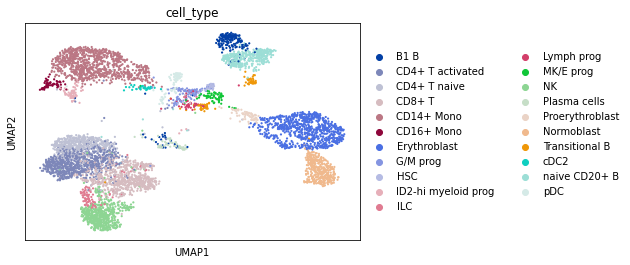

In [162]:
# adata_RNA

# 1) adata.X
# log-normalize the raw counts in adata.X
# recover the raw counts
adata_RNA.X = adata_RNA.layers["counts"].copy()
adata_RNA.X.todense()
# log-normalize the counts for RNA object
sc.pp.normalize_total(adata_RNA, target_sum=1e4)
sc.pp.log1p(adata_RNA)

# create a dataframe with obs and var as indicex and columns
df_counts_RNA = pd.DataFrame(adata_RNA.X.todense(), 
                             index=adata_RNA.obs_names,
                             columns=adata_RNA.var_names)

# sort the index
df_counts_RNA = df_counts_RNA.sort_index()
adata_RNA.X = sparse.csr_matrix(df_counts_RNA.to_numpy())


# 2) adata.obsm
df_umap = pd.DataFrame(adata_RNA.obsm["X_umap"],
                  index = adata_RNA.obs_names)

df_umap = df_umap.sort_index()
adata_RNA.obsm["X_umap"] = df_umap.to_numpy()

# 3) adata.obs
adata_RNA.obs = adata_RNA.obs.sort_index()
adata_RNA.obs

adata_RNA.obs

sc.pl.umap(adata_RNA, color="cell_type")

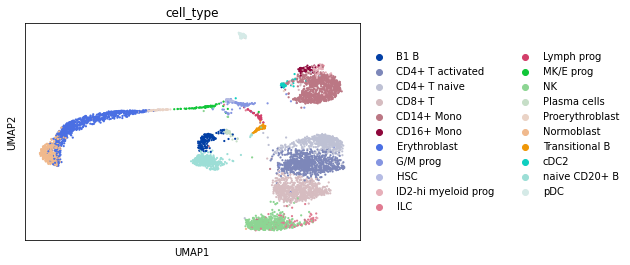

In [163]:
# adata_ATAC_genes

# 1) adata.X
# log-normalize the raw counts in adata.X -> ATAC data is not integer counts (or we never saved it separately)
# recover the raw counts
# adata_ATAC_genes.X = adata_ATAC_genes.layers["counts"].copy()
# adata_ATAC_genes.X.todense()
# log-normalize the counts for RNA object
# sc.pp.normalize_total(adata_RNA, target_sum=1e4)
# sc.pp.log1p(adata_RNA)

# create a dataframe with obs and var as indicex and columns
df_counts_ATAC = pd.DataFrame(adata_ATAC_genes.X.todense(), 
                             index=adata_ATAC_genes.obs_names,
                             columns=adata_ATAC_genes.var_names)

# sort the index
df_counts_ATAC = df_counts_ATAC.sort_index()
adata_ATAC_genes.X = sparse.csr_matrix(df_counts_ATAC.to_numpy())

# 2) adata.obsm
df_umap = pd.DataFrame(adata_ATAC_genes.obsm["X_umap"],
                  index = adata_ATAC_genes.obs_names)

df_umap = df_umap.sort_index()
adata_ATAC_genes.obsm["X_umap"] = df_umap.to_numpy()

# 3) adata.obs
adata_ATAC_genes.obs = adata_ATAC_genes.obs.sort_index()
adata_ATAC_genes.obs

sc.pl.umap(adata_ATAC_genes, color="cell_type")

## Step1. Concatenate the two anndata objects

In [164]:
# Alternatively, we can concatenate two anndata objects using ad.concat

# Put the assay name for adata.var just in case we need to differentiate where the marker comes from (usually it shoudl be obvious!)
adata_RNA.var['assay'] = 'RNA'
adata_ATAC_genes.var['assay'] = 'ATAC'

# NOTE: the order of the adata.obs should matter in terms of concatenation (which is weird), 
# so we'd need to sort the orders of both adata objects before the concatenation (done in the previous step)

# concatenate the two adata objects
adata_joint = ad.concat([adata_RNA, adata_ATAC_genes], axis=1, merge="first")

# transfer annotations from both modalities
adata_joint.obs["cell_type_RNA"] = adata_ATAC_genes.obs["rna_ann"]
adata_joint.obs["cell_type_ATAC"] = adata_RNA.obs["atac_ann"]

adata_joint

AnnData object with n_obs × n_vars = 6224 × 36852
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'pseudotime_order_GEX', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'pseudotime_order_ATAC', 'cell_type_RNA', 'cell_type_ATAC'
    var: 'assay'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [165]:
# remove unnecessary fields (or fields partially filled with NaNs, that cause errors in exCellxgene)
# Tip. generalize this to remove any fields filled with NaNs.
del adata_joint.obs["pseudotime_order_ATAC"]
del adata_joint.obs["pseudotime_order_GEX"]
# del adata_joint.obs["atac_ann"]
# del adata_joint.obs["rna_ann"]
del adata_joint.obsm["X_umap"]


/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'assay' as categorical


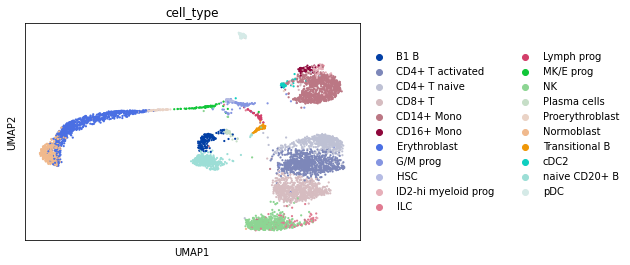

In [166]:
sc.pl.umap(adata_ATAC_genes, color="cell_type")

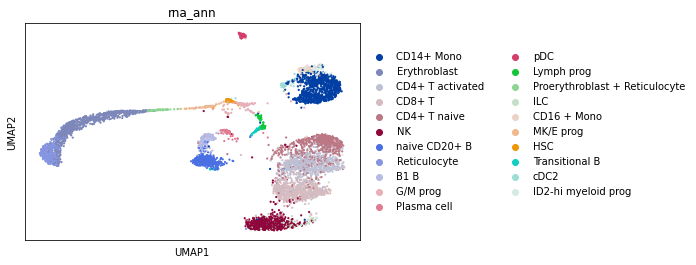

In [167]:
sc.pl.umap(adata_ATAC_genes, color="rna_ann")

## Step2. Save the useful embeddings from each adata

In [168]:
# save the UMAP embeddings from both RNA and ATAC
adata_joint.obsm["X_umap_RNA"] = adata_RNA.obsm["X_umap"]
adata_joint.obsm["X_umap_ATAC"] = adata_ATAC_genes.obsm["X_umap"]

In [169]:
adata_joint

AnnData object with n_obs × n_vars = 6224 × 36852
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC'
    var: 'assay'
    obsm: 'X_pca', 'X_umap_RNA', 'X_umap_ATAC'
    obsp: 'connectivities', 'distances'

In [171]:
adata_joint.write_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_RNA_ATAC_concat_test10.h5ad")

### Sanity check


/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataF

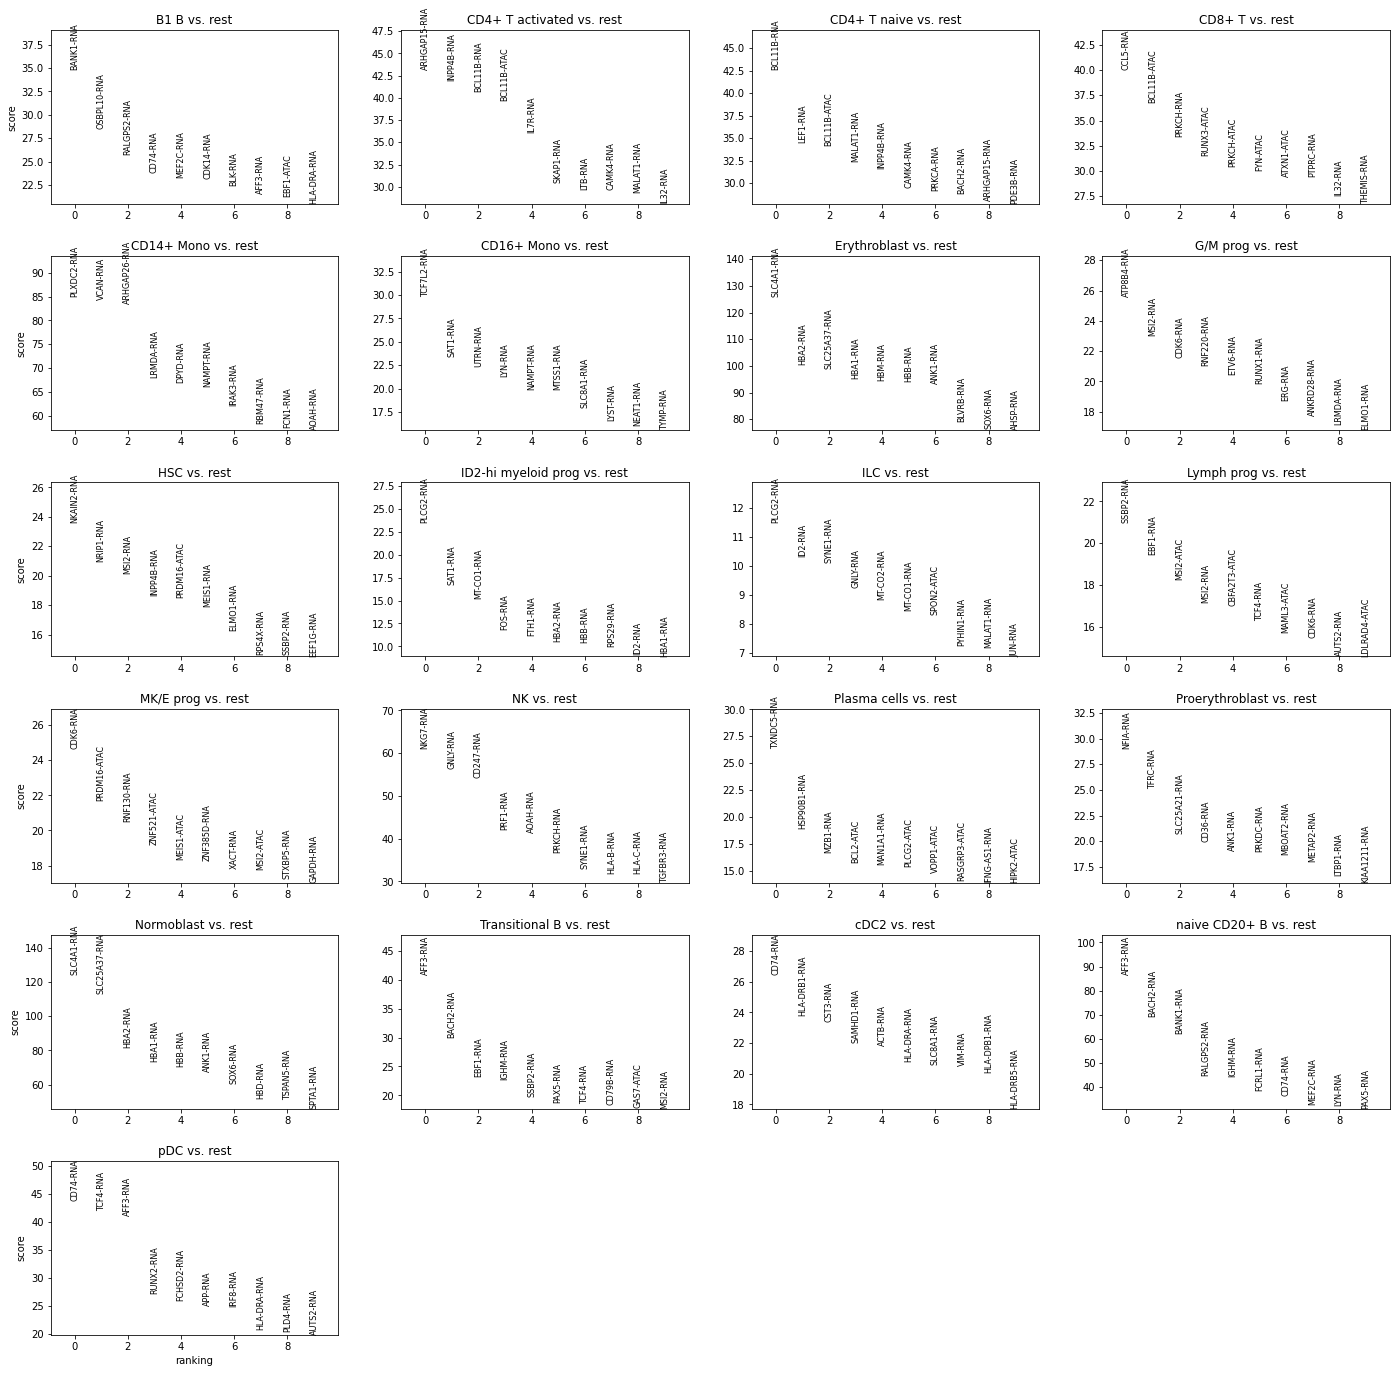

In [174]:
sc.tl.rank_genes_groups(adata_joint, "cell_type", method="t-test", key_added = "t-test")
sc.pl.rank_genes_groups(adata_joint, n_genes=10, sharey=False, key="t-test")

In [172]:
# check if the adata.obs mapping was done systematically between the joint adata object and the adata_ATAC_genes
adata_joint[adata_joint.obs["cell_type_ATAC"]=="B1 B"].obs_names.isin(adata_ATAC_genes.obs["cell_type"]=="B1 B")

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [181]:
adata_ATAC_genes[adata_ATAC_genes.obs["cell_type"]=="B1 B"]

View of AnnData object with n_obs × n_vars = 201 × 19039
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'leiden_final', 'rna_ann', 'cell_type', 'pseudotime_order_ATAC'
    var: 'assay'
    obsm: 'X_umap'

/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.var` of view, copying.
... storing 'assay' as categorical


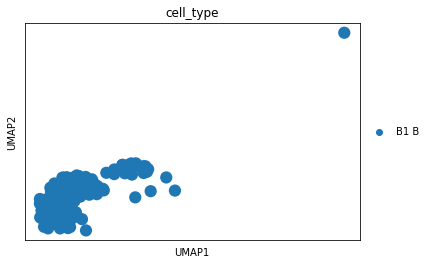

In [182]:
sc.pl.umap(adata_ATAC_genes[adata_ATAC_genes.obs["cell_type"]=="B1 B"], color="cell_type")

/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.var` of view, copying.
... storing 'assay' as categorical


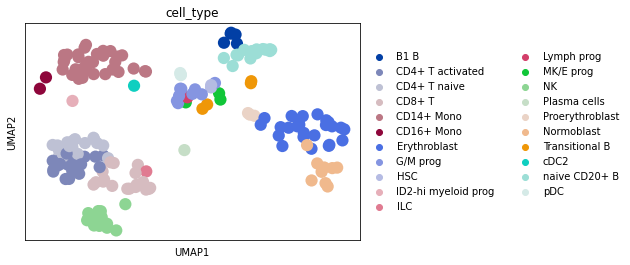

In [183]:
sc.pl.umap(adata_RNA[adata_ATAC_genes.obs["cell_type"]=="B1 B"], color="cell_type")

In [185]:
adata_ATAC_genes.obs["cell_type"]

TCGCGAGGTTAGCAGC-1                          NK
GAGTGATCATTGTGCA-1            CD4+ T activated
GTCCATTGTTATTGCC-1                         HSC
CGTCCTAGTGGATTGC-1                        pDCs
GACAATACATGACTAT-1                        pDCs
                                ...           
TGGACGGAGTCACGAT-1                Reticulocyte
GCATATATCCCTCGCA-1            CD4+ T activated
TCACTGACAACACCTA-1    CD4+ T activated, CD8+ T
GCCAGGTTCAGGAACA-1                Reticulocyte
CATGGATTCTCCATGC-1                          NK
Name: cell_type, Length: 6224, dtype: category
Categories (22, object): ['CD14+ Mono, ID2-hi myeloid prog', 'CD14+ Mono, CD16+ Mono', 'CD14+ Mono, cDC2', 'CD4+ T activated', ..., 'CD4+ T naive', 'Proerythroblast, Erythroblast', 'B1 B', 'Plasma cells']

In [147]:
adata_RNA[adata_RNA.obs["cell_type"]=="Erythroblast"]

View of AnnData object with n_obs × n_vars = 797 × 17813
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'pseudotime_order_GEX'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable'
    uns: 'hvg', 'neighbors', 'pca', 'rg_res0.5_4sub', 'rg_res0.5_msub3', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [151]:
adata_RNA[adata_ATAC.obs["cell_type"]=="Erythroblast"][adata_RNA[adata_ATAC.obs["cell_type"]=="Erythroblast"].obs["cell_type"]=="Erythroblast"]

View of AnnData object with n_obs × n_vars = 96 × 17813
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'pseudotime_order_GEX'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable'
    uns: 'hvg', 'neighbors', 'pca', 'rg_res0.5_4sub', 'rg_res0.5_msub3', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'assay' as categorical


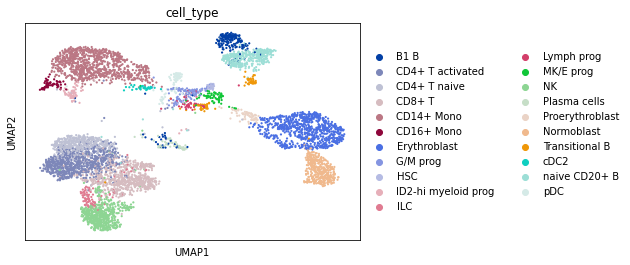

In [100]:
sc.pl.umap(adata_RNA, color="cell_type")

In [113]:
adata_RNA[adata_ATAC.obs["cell_type"]=="Erythroblast"].obs["cell_type"]

TCATTTGGTAATGGAA-1          CD8+ T
TTACCTGTCTATGACA-1              NK
GGCAATCGTTAGGACC-1      Normoblast
ATGTGAGAGGCGAAAC-1          CD8+ T
GAGCTGCTCTTGTCCA-1          CD8+ T
                          ...     
ACCAGGACAGTACCGT-1            cDC2
TAGCTAATCATGAGCT-1      CD14+ Mono
GTGCATTAGCACTAGT-1              NK
TGTAAGCTCATTGCAA-1    Erythroblast
CATAATGTCCTTCTAG-1    Erythroblast
Name: cell_type, Length: 797, dtype: category
Categories (21, object): ['B1 B', 'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', ..., 'Transitional B', 'cDC2', 'naive CD20+ B', 'pDC']

In [112]:
adata_ATAC[adata_RNA.obs["cell_type"]=="Erythroblast"].obs["cell_type"]

AAACCGAAGCGGATAA-1        CD4+ T naive
AAACCGCGTAAACAAG-1              CD8+ T
AAACCGCGTGCTCCGT-1       naive CD20+ B
AAACGTACACAGAACG-1                B1 B
AAAGCACCAAGTAAGC-1          Normoblast
                            ...       
TTTGTCCCATGGAGGC-1                 HSC
TTTGTCTAGCCGCAGT-1          CD14+ Mono
TTTGTCTAGTCACTAA-1    CD4+ T activated
TTTGTGAAGTAACGAG-1                  NK
TTTGTGAAGTAGCGGG-1        Erythroblast
Name: cell_type, Length: 797, dtype: category
Categories (21, object): ['B1 B', 'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', ..., 'Transitional B', 'cDC2', 'naive CD20+ B', 'pDC']

## Generate plots for the manuscript

- generate UMAP embeddings from each modality, with annotations from each modality (also projected into another modality)

- RNA UMAP + RNA annotation
- ATAC UMAP + ATAC annotation
- RNA UMAP + ATAC annotation projected
- ATAC UMAP + RNA annotation projected
- joint annotation -> RNA and ATAC

In [5]:
# load the dataset
adata_joint = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_RNA_ATAC_concat_test10.h5ad")
adata_joint

AnnData object with n_obs × n_vars = 6224 × 36852
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC'
    var: 'assay'
    obsm: 'X_pca', 'X_umap_ATAC', 'X_umap_RNA'
    obsp: 'connectivities', 'distances'

In [9]:
# define the figure path
figpath = "/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/excellxgene_tutorials/figures/"
sc.settings.figdir = figpath

In [21]:
cell_type_list_RNA = adata_joint.obs["cell_type_RNA"].unique().to_list()
cell_type_list_RNA

['CD4+ T naive',
 'Lymph prog',
 'Erythroblast',
 'CD8+ T',
 'CD4+ T activated',
 'B1 B',
 'CD14+ Mono',
 'naive CD20+ B',
 'HSC',
 'NK',
 'pDC',
 'G/M prog',
 'Reticulocyte',
 'CD16 + Mono',
 'MK/E prog',
 'Proerythroblast + Reticulocyte',
 'ILC',
 'ID2-hi myeloid prog',
 'cDC2',
 'Transitional B',
 'Plasma cell']

In [20]:
cell_type_list_ATAC = adata_joint.obs["cell_type_ATAC"].unique().to_list()
cell_type_list_ATAC

['CD4+ T naive',
 'Lymph prog',
 'CD4+ T activated',
 'Proerythroblast, Erythroblast',
 'CD4+ T activated, CD8+ T',
 'Naive CD20+ B',
 'CD14+ Mono, ID2-hi myeloid prog',
 'HSC',
 'NK',
 'Erythroblast, Reticulocyte',
 'pDCs',
 'B1 B',
 'Reticulocyte',
 'ILC',
 'CD14+ Mono, CD16+ Mono',
 'MK/E prog',
 'HSPC/Mono prog',
 'low quality T cells',
 'CD14+ Mono, cDC2',
 'Transitional B',
 'Plasma cells',
 'low quality cells']

In [29]:
set(cell_type_list_ATAC).intersection(set(cell_type_list_RNA))

{'B1 B',
 'CD4+ T activated',
 'CD4+ T naive',
 'HSC',
 'ILC',
 'Lymph prog',
 'MK/E prog',
 'NK',
 'Reticulocyte',
 'Transitional B'}

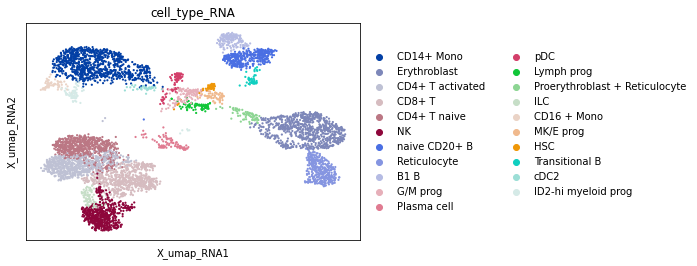

In [11]:
# RNA UMAP with RNA annotations
sc.pl.embedding(adata_joint, basis="X_umap_RNA", color="cell_type_RNA", 
                save="_neurips_s1d1_RNA_UMAP+RNA_annotation.pdf")

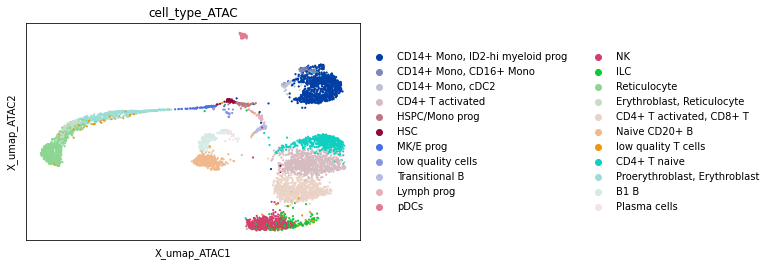

In [12]:
# ATAC UMAP with ATAC annotations
sc.pl.embedding(adata_joint, basis="X_umap_ATAC", color="cell_type_ATAC", 
                save="_neurips_s1d1_ATAC_UMAP+ATAC_annotation.pdf")

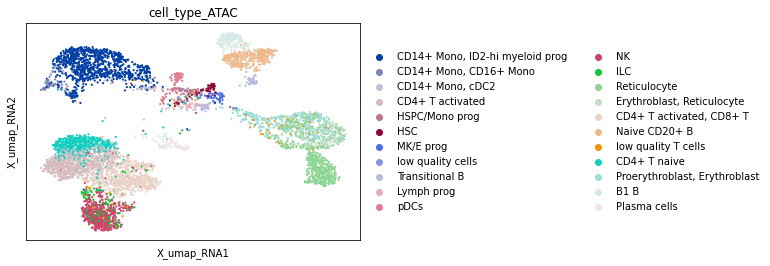

In [13]:
# RNA UMAP with ATAC annotations
sc.pl.embedding(adata_joint, basis="X_umap_RNA", color="cell_type_ATAC", 
                save="_neurips_s1d1_RNA_UMAP+ATAC_annotation.pdf")

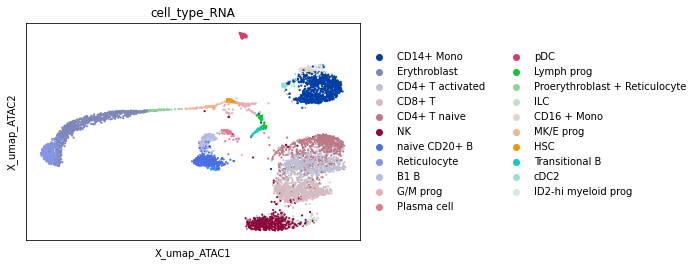

In [14]:
# ATAC UMAP with RNA annotations
sc.pl.embedding(adata_joint, basis="X_umap_ATAC", color="cell_type_RNA", 
                save="_neurips_s1d1_ATAC_UMAP+RNA_annotation.pdf")

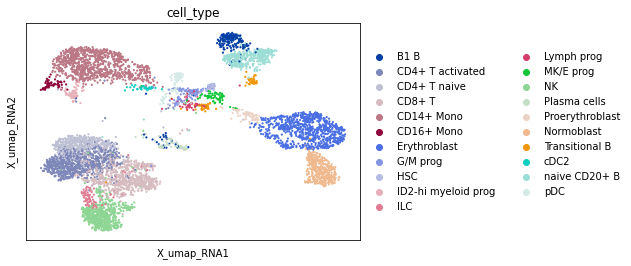

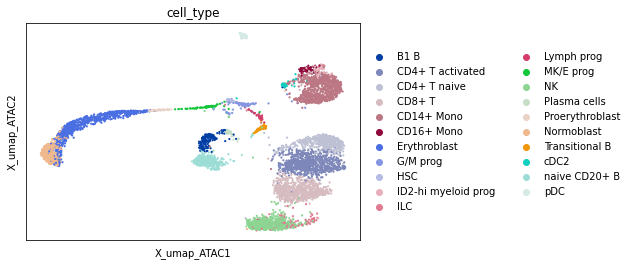

In [15]:
# RNA UMAP and ATAC UMAP with final joint annotations
sc.pl.embedding(adata_joint, basis="X_umap_RNA", color="cell_type", 
                save="_neurips_s1d1_RNA_UMAP+joint_annotation.pdf")

sc.pl.embedding(adata_joint, basis="X_umap_ATAC", color="cell_type", 
                save="_neurips_s1d1_ATAC_UMAP+joint_annotation.pdf")